In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import *
from sklearn.metrics import rand_score, accuracy_score, silhouette_score, adjusted_rand_score, v_measure_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

image = np.load('salinas_image.npy')
gt = np.load('salinas_labels.npy')

In [2]:
crop_type = ["Undefined", "Brocoli_green_weeds_1", "Brocoli_green_weeds_2", "Fallow","Fallow_rough_plow",
             "Fallow_smooth", "Stubble","Celery", "Grapes_untrained","Soil_vinyard_develop",
             "Corn_senesced_green_weeds","Lettuce_romaine_4wk", "Lettuce_romaine_5wk",
             "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", "Vinyard_untrained", "Vinyard_vertical_trellis"]

In [3]:
class HSI_Classification():
    def __init__(self, image, gt, labels):
        self.image = image
        self.gt = gt
        self.labels = labels
        self.rows, self.cols, self.bands = self.image.shape
        self.pixels = self.rows*self.cols
        self.imr = None
        self.gtr = None
        self.bands_list = []
        for i in range(0,self.bands):
            self.bands_list.append(self.image[:,:,i])
        self.df_setup()
        self.pixel_count = []
        for i in range(0, self.number_of_different_categories()): 
            self.pixel_count.append((gt==i).sum())
            
    def df_setup(self):
        self.imr = np.reshape(self.image,(self.pixels,self.bands))
        self.gtr = np.reshape(self.gt,(self.pixels, 1))
        self.df = pd.DataFrame(self.imr)
        self.df['gt'] = pd.DataFrame(self.gtr)
        self.df['labels'] = self.df['gt'].apply(lambda x: crop_type[x])
    
    def df_clean(self):
        self.df = self.df[self.df['gt']!=0]
    
    def return_df(self):
        df = self.df
        return df
    
    def extract_X_y(self):
        X = pd.DataFrame(self.df.iloc[:,:-2])
        y = pd.DataFrame(self.df.iloc[:,-2])
        return X,y
    
    def draw_bands(self, a, b, c):
        fig, axes = plt.subplots(1,3,figsize=(10,10))
        (ax_1, ax_2, ax_3) = axes

        ax_1.imshow(self.bands_list[a-1])
        ax_1.set_title(f'Band {a}')

        ax_2.imshow(self.bands_list[b-1])
        ax_2.set_title(f'Band {b}')

        ax_3.imshow(self.bands_list[c-1])
        ax_3.set_title(f'Band {c}');
    
    def return_shape(self):
        rows, cols, bands = self.rows, self.cols, self.bands
        return rows, cols, bands
    
    def number_of_different_categories(self):
        return len(np.unique(gt))
    
    def draw_labels(self):
        plt.figure(figsize=(8, 6))
        im = plt.imshow(list(self.gt), label = 'Labels')
        values = np.unique(self.df.iloc[:,-2].ravel())
        colors = [ im.cmap(im.norm(value)) for value in values]
        patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values))]
        plt.title('Labels')
        plt.legend(handles=patches, labels = self.labels, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show;
        
    def draw_clmap(self, y_pred):
        plt.figure(figsize=(8, 6))
        im = plt.imshow(np.array(y_pred).reshape((512, 217)), cmap='jet')
        values = np.unique(self.df.iloc[:,-2].ravel())
        colors = [ im.cmap(im.norm(value)) for value in values]
        patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values))]
        plt.title('CL Map')
        plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show();
        
    def return_pixel_count(self):
        count = self.pixel_count
        return count
    
    def get_random_pixels(self):
        random_pixels = []
        for i in range(1, 17):
            indeces = np.where(self.gtr==i)
            random_pixels.append(indeces[0][np.random.randint(0, len(indeces[0]))])
        return random_pixels
    
    def plot_pixel_signature(self, random_pixels):
        for i in range(0, 16):    
            plt.plot(self.imr[random_pixels[i],:])
            plt.legend(np.delete(self.labels,0), loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Random Pixel for Every Type (Signature)');
        
    def get_corr_matrix(self, df):
        return df.corr()
        
    def normalize(self, df):
        scaler = MinMaxScaler()
        scaler.fit(df)
        scaled = scaler.fit_transform(df)
        return pd.DataFrame(scaled, columns = df.columns)
    
    def show_pixel(self, pixel, n):
        ax = plt.gca()
        im = ax.imshow(pixel.reshape(12, 17), cmap = 'jet')
        plt.title(f'pixel - {n}')
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        plt.show();
    
    def choose_centroids(self): 
        centroids = []
        for i in range(1, 17):
            centroids.append(self.df[self.df['gt']==i].iloc[0,:].values[:-2].astype('int32'))
        centroids = np.array(centroids).astype('double')
        return centroids
    
    def transform_predictions(self, y_pred):
        y_pred_df = pd.DataFrame(y_pred)
        y_pred_df = y_pred_df.set_index(y.index)
        new_index = list(range(111104))
        y_pred_df = y_pred_df.reindex(new_index, fill_value=0)
        return y_pred_df

In [4]:
hsi = HSI_Classification(image, gt, crop_type)
hsi.df_clean()

In [5]:
df = hsi.return_df()

In [6]:
df

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,gt,labels
305,369,558,787,1387,1765,1852,1820,2038,2372,2460,...,122,94,58,83,59,30,5,14,6,Stubble
306,441,474,787,1344,1706,1852,1800,2022,2328,2473,...,116,98,64,87,55,32,11,25,6,Stubble
307,441,558,787,1344,1706,1830,1781,2022,2343,2473,...,116,96,60,83,63,26,11,16,6,Stubble
308,441,558,787,1344,1735,1830,1800,2038,2386,2512,...,118,104,56,85,51,32,7,12,6,Stubble
309,441,474,787,1344,1735,1875,1858,2104,2430,2564,...,114,94,54,81,55,26,9,16,6,Stubble
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110689,299,483,540,921,1116,1148,1067,1136,1253,1256,...,37,36,18,26,17,9,4,15,16,Vinyard_vertical_trellis
110690,299,316,540,879,1116,1125,1067,1136,1253,1269,...,35,26,16,24,15,7,12,2,16,Vinyard_vertical_trellis
110691,299,232,474,836,1116,1125,1028,1119,1239,1269,...,26,21,12,15,11,9,0,6,16,Vinyard_vertical_trellis
110692,299,316,540,836,1087,1125,1048,1119,1253,1243,...,28,26,14,28,17,5,2,4,16,Vinyard_vertical_trellis


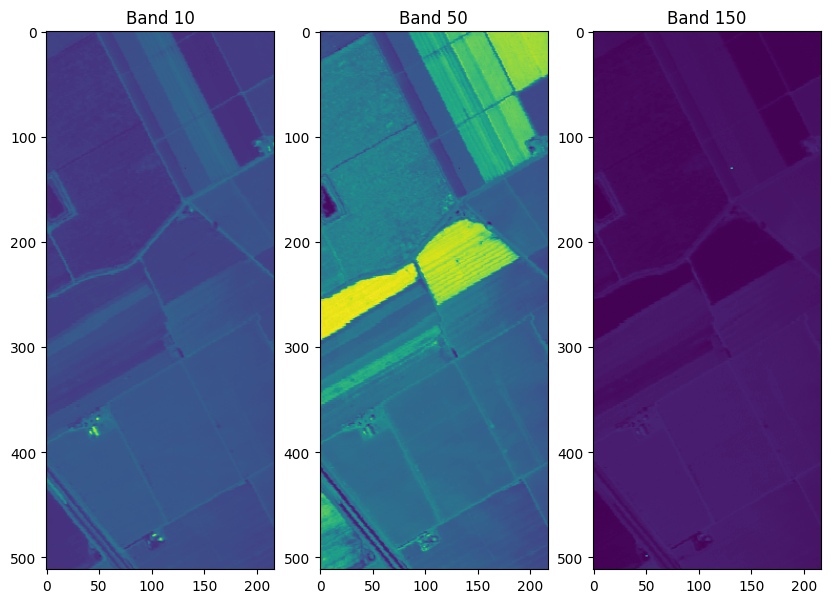

In [7]:
hsi.draw_bands(10, 50, 150)

In [8]:
height, width, bands = hsi.return_shape()
print(height, width, bands)

512 217 204


In [9]:
hsi.number_of_different_categories()

17

In [10]:
X, y = hsi.extract_X_y()

In [11]:
X

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
305,369,558,787,1387,1765,1852,1820,2038,2372,2460,...,118,100,122,94,58,83,59,30,5,14
306,441,474,787,1344,1706,1852,1800,2022,2328,2473,...,116,104,116,98,64,87,55,32,11,25
307,441,558,787,1344,1706,1830,1781,2022,2343,2473,...,113,102,116,96,60,83,63,26,11,16
308,441,558,787,1344,1735,1830,1800,2038,2386,2512,...,116,94,118,104,56,85,51,32,7,12
309,441,474,787,1344,1735,1875,1858,2104,2430,2564,...,116,102,114,94,54,81,55,26,9,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110689,299,483,540,921,1116,1148,1067,1136,1253,1256,...,36,29,37,36,18,26,17,9,4,15
110690,299,316,540,879,1116,1125,1067,1136,1253,1269,...,30,29,35,26,16,24,15,7,12,2
110691,299,232,474,836,1116,1125,1028,1119,1239,1269,...,24,21,26,21,12,15,11,9,0,6
110692,299,316,540,836,1087,1125,1048,1119,1253,1243,...,24,25,28,26,14,28,17,5,2,4


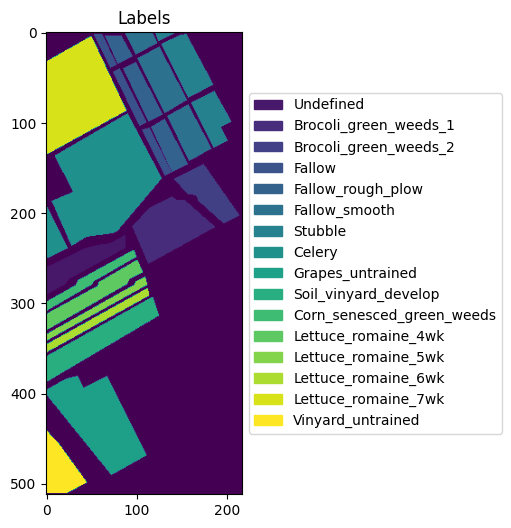

In [12]:
hsi.draw_labels()

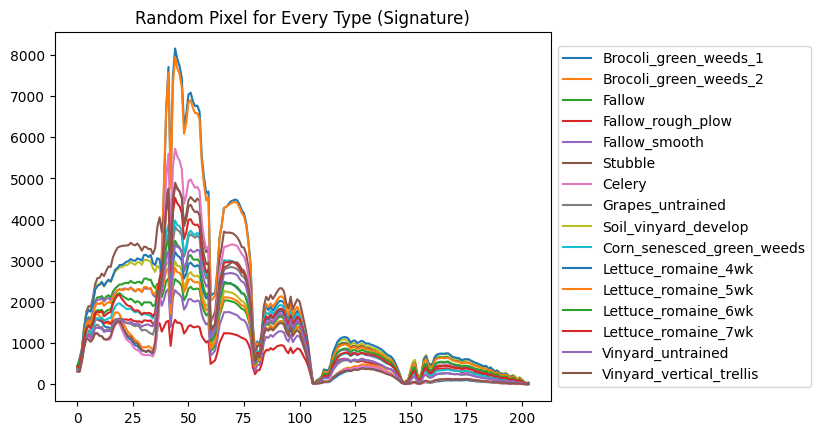

In [13]:
hsi.plot_pixel_signature(hsi.get_random_pixels())

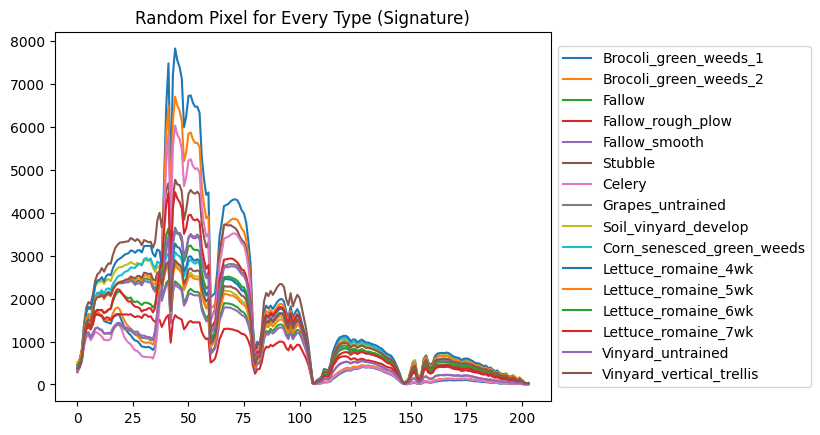

In [14]:
hsi.plot_pixel_signature(hsi.get_random_pixels())

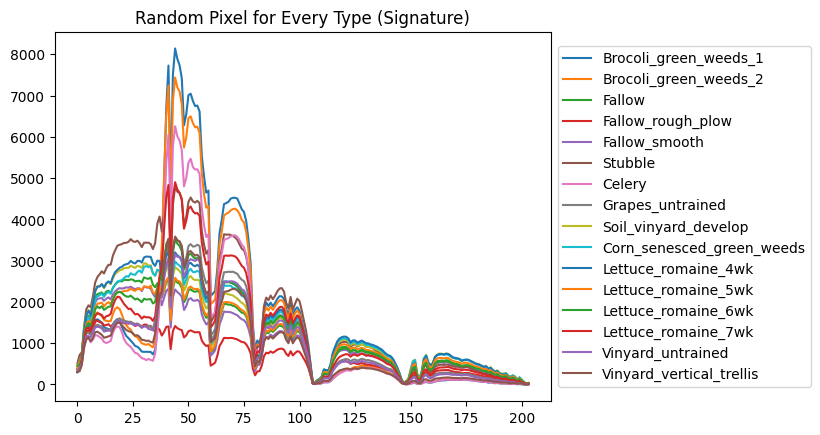

In [15]:
hsi.plot_pixel_signature(hsi.get_random_pixels())

In [16]:
rand_n = np.random.randint(df.shape[0])
rand_n

47442

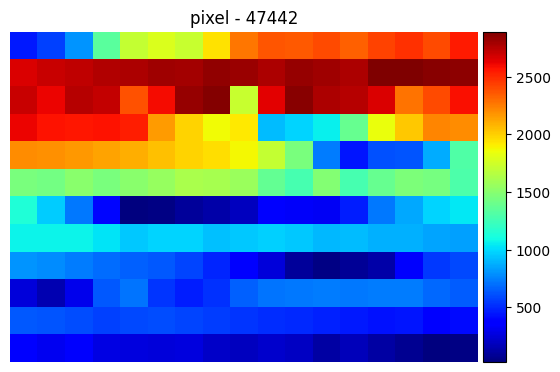

In [17]:
hsi.show_pixel(X.iloc[rand_n, :].values, rand_n)

''

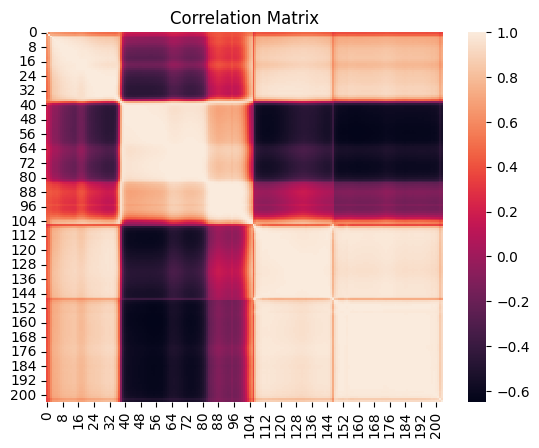

In [18]:
corr_matrix = hsi.get_corr_matrix(X)
import seaborn as sns 
ax = sns.heatmap(corr_matrix)
ax.set_title('Correlation Matrix')
;

In [30]:
centroids = hsi.choose_centroids()

In [31]:
kmeans = KMeans(n_clusters=16)
kmeans.fit(X)
kmeans.cluster_centers_ = centroids
y_pred = kmeans.predict(X)
y_np = y.to_numpy()
adjusted_rand_score(y_pred.flatten(), y_np.flatten())

0.5507462821173218

In [32]:
y_pred = hsi.transform_predictions(y_pred)

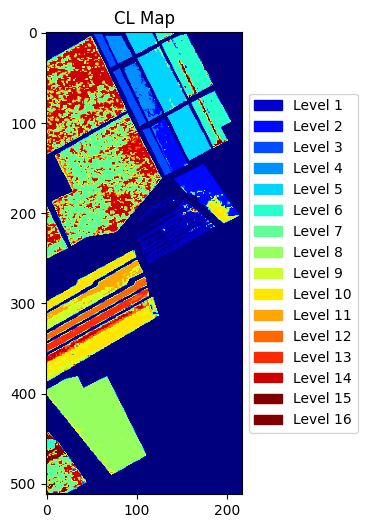

In [33]:
hsi.draw_clmap(y_pred)

In [37]:
pca = PCA(n_components=100)
X_new = pca.fit_transform(X)
kmeans = KMeans(n_clusters=16)
y_pred = kmeans.fit_predict(X_new)
adjusted_rand_score(y_pred.flatten(), y_np.flatten())

0.5261708285862273

In [38]:
y_pred = hsi.transform_predictions(y_pred)

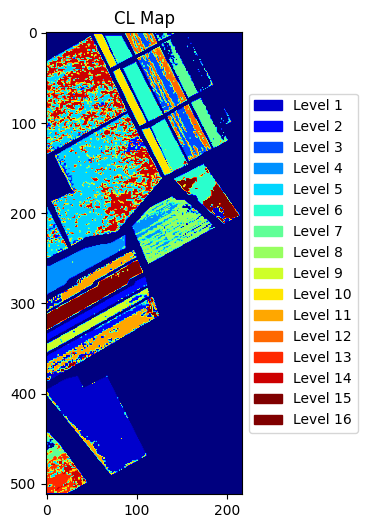

In [39]:
hsi.draw_clmap(y_pred)

In [40]:
X_train = hsi.normalize(X)
kmeans = KMeans(n_clusters=16)
y_pred = kmeans.fit_predict(X_train)
adjusted_rand_score(y_pred.flatten(), y_np.flatten())

0.5216461484485552

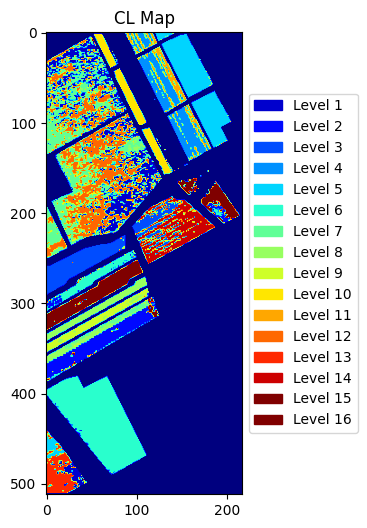

In [42]:
y_pred = hsi.transform_predictions(y_pred)
hsi.draw_clmap(y_pred)